In [2]:
import pandas as pd

import jax
import jax.lax as lax
import jax.numpy as jnp
from jax.random import key, split, uniform

from tqdm import tqdm

import matplotlib.pyplot as plt


jax.config.update("jax_enable_x64", True)
jnp.set_printoptions(precision=3)

In [12]:
import os
from pathlib import Path

from sklearn.metrics import r2_score

data_dir = Path("indicator_data/lin_reg")

data = []

threshold = .9

for file in os.listdir(data_dir):
    df = pd.read_csv(data_dir / file)
    df['time_stamp'] = pd.to_datetime(df['time_stamp'])
    cutoff = df.training_cutoff.iloc[0]

    # If the R2 score on the training segement is below 0.9, 
    # we assume the NBM is not performing well and it is cut
    score = r2_score(df.target.to_numpy()[:cutoff], df.predictions.to_numpy()[:cutoff])

    if score < threshold:
        print(file, 'excluded from training, r2 =', round(score, 3), '<', threshold)
        continue

    data += [df]



residuals_10.csv excluded from training, r2 = 0.093 < 0.9


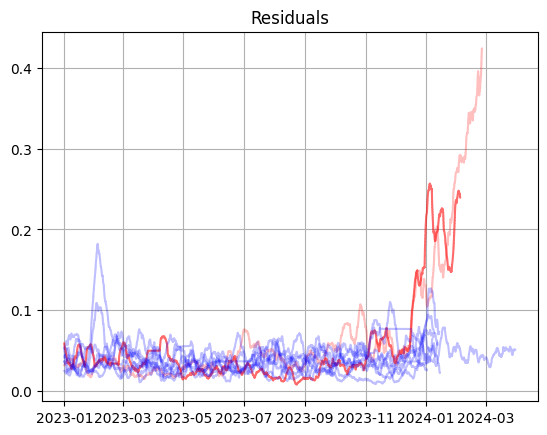

In [18]:
from datetime import datetime
import numpy as np

def normalize_timestamp(x):
    x = x - x.iloc[0]
    return datetime(year=2023, month=1, day=1) + x

window = 6 * 25 * 7
anom_count = 0
for df in data:
    x = normalize_timestamp(df.time_stamp[window-1:])
    
    y = np.convolve(df.residual, np.ones(window)/window, mode='valid')
    label = df['label'].iloc[0]
    color = 'blue'
    alpha = 0.25
    if label == 'anomaly':
        color = 'red'
        alpha = 0.25 + anom_count/3
        anom_count += 1
    plt.step(x, y, color=color, alpha=alpha)
plt.grid()
plt.title('Residuals')
plt.show()

100%|██████████| 10/10 [00:00<00:00, 76.13it/s]


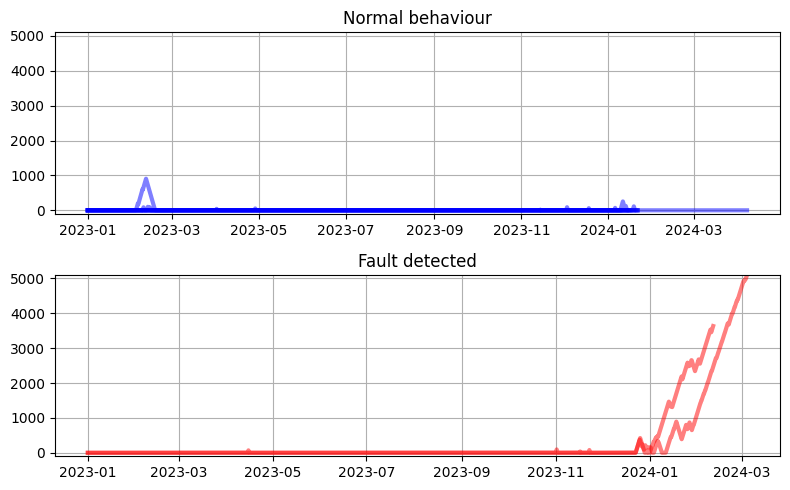

In [23]:
import matplotlib.pyplot as plt
import numpy as np

def criticality(residuals, threshold):
    crit = np.zeros_like(residuals)
    residuals = np.array(residuals)

    for k in range(len(residuals)):
        if residuals[k] > threshold:
            crit[k] = crit[k-1] + 1# min(residuals[k], 1)
        else:
            crit[k] = max(crit[k-1] - 1, 0)

    return crit

fig, ax = plt.subplots(2)
fig.set_size_inches(8,5)

linewidth = 3.0

crit_threshold = 0.15

good_data = []

max_ys = 0

for df in tqdm(data):
    label = str(df["label"].iloc[0])

    # ys_raw = np.split(df['residual'], 400)
    ys_raw = np.convolve(df['residual'], np.ones(100)/100, mode='valid')
    
    ys = criticality(ys_raw, threshold=crit_threshold)
    x = normalize_timestamp(df["time_stamp"][99:])

    if max(ys) > max_ys:
        max_ys = max(ys)

    if label == "normal":
        ax[0].plot(x, ys, alpha=0.5, color="blue", linewidth=linewidth)
    else:
        ax[1].plot(x, ys, alpha=0.5, color="red", linewidth=linewidth)
    
    good_data.append(df)
    

for _ax in ax:
    _ax.grid()
    _ax.set_ylim(-100, max_ys)

ax[0].set_title("Normal behaviour")
ax[1].set_title("Fault detected")
plt.tight_layout()
plt.show()


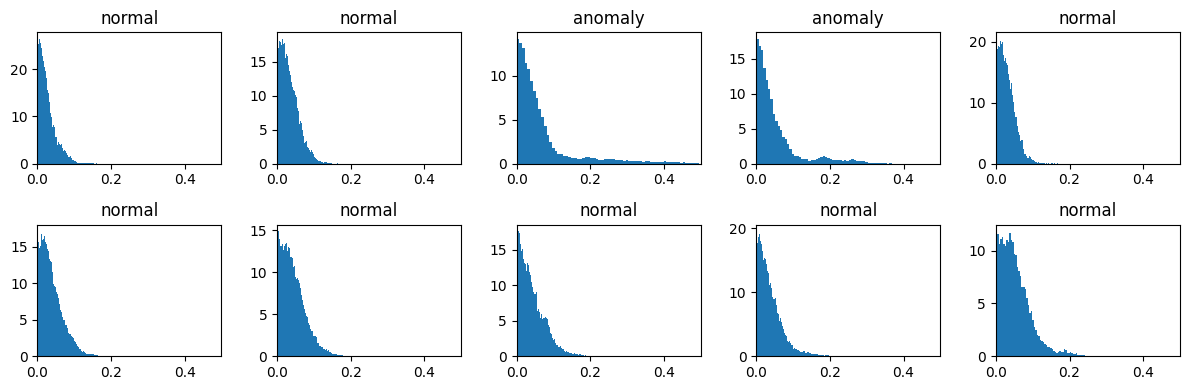

In [30]:
ys = criticality(df["residual"], threshold=0.1)
fig, axs = plt.subplots(2, 5)

fig.set_size_inches(12, 4)

for k, df in enumerate(good_data):
    coord = k //5, k%5
    axs[*coord].hist(df.residual, bins = 100, density=True)
    axs[*coord].set_xlim(0, 0.5)
    axs[*coord].set_title(df["label"].iloc[0])

plt.tight_layout()
plt.show()

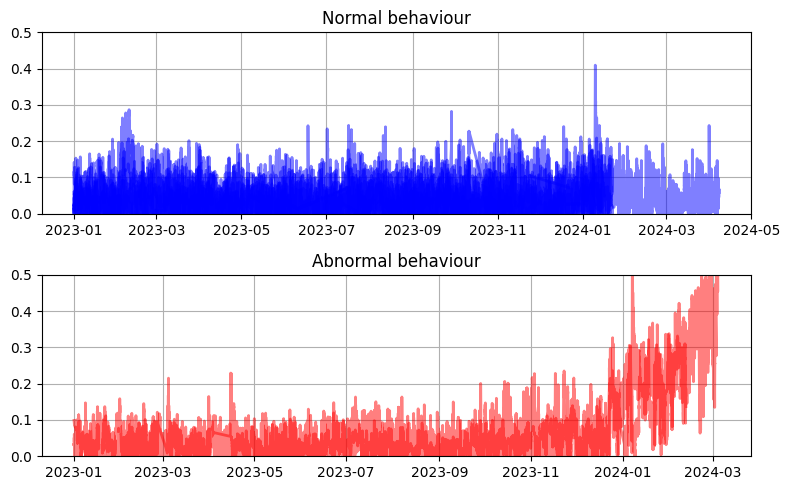

In [34]:
fig, ax = plt.subplots(2)
fig.set_size_inches(8,5)

linewidth = 2.0

for df in good_data:
    label = str(df["label"].iloc[0])
    
    xs = normalize_timestamp(df["time_stamp"])
    ys = df["residual"]

    if label == "normal":
        ax[0].plot(xs, ys, alpha=0.5, color="blue", linewidth=linewidth)
    else:
        ax[1].plot(xs, ys, alpha=0.5, color="red", linewidth=linewidth)
for _ax in ax:
    _ax.grid()
    _ax.set_ylim(0,0.5)
ax[0].set_title("Normal behaviour")
ax[1].set_title("Abnormal behaviour")
plt.tight_layout()
plt.show()


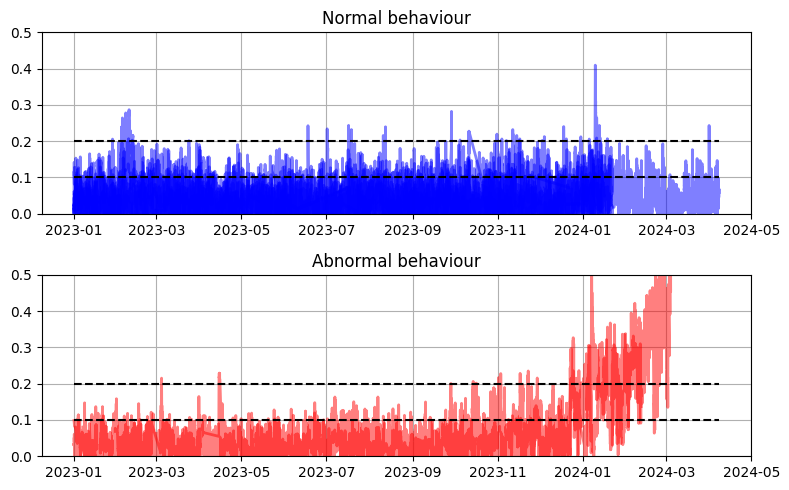

58609 46724


In [42]:
fig, ax = plt.subplots(2)
fig.set_size_inches(8,5)

linewidth = 2.0

bin_borders = [0.1, 0.2]

x_max = [0]
min_len = 1e20
for df in good_data:
    label = str(df["label"].iloc[0])
    
    xs = normalize_timestamp(df["time_stamp"])
    ys = df["residual"]

    if len(xs) > len(x_max):
        x_max = xs.to_numpy()
    if len(xs) < min_len:
        min_len = len(xs)

    if label == "normal":
        ax[0].plot(xs, ys, alpha=0.5, color="blue", linewidth=linewidth)
    else:
        ax[1].plot(xs, ys, alpha=0.5, color="red", linewidth=linewidth)
for _ax in ax:
    _ax.grid()
    _ax.set_ylim(0,0.5)
    _ax.hlines(bin_borders, x_max[0], x_max[-1], colors="black", linestyles='dashed')
ax[0].set_title("Normal behaviour")
ax[1].set_title("Abnormal behaviour")

plt.tight_layout()
plt.show()
print(len(x_max), min_len)


# TODO

For the bearing failure event with the standstill, add another observation that indicates certain failure!!

324.0


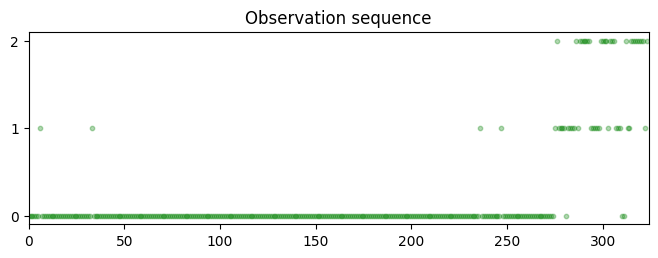

array([[0, 0, 0, ..., 0, 0, 1],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 2, 2, 2],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 1]], shape=(10, 324))

In [70]:
truncated = np.array([df["residual"].to_numpy()[-46656:] for df in good_data])

print(truncated.shape[1] / (6*24))

residual_means = np.mean(truncated.reshape(10, 324, 6*24), axis=-1)

bin_borders_inf = [-np.inf, *bin_borders, np.inf]

sequences = []

for row in residual_means:
    seq = np.digitize(row, bin_borders)
    sequences.append(seq)


observations = np.array(sequences)
# observations[1, -10:] = len(bin_borders) + 1


window_size= 20
plt.gcf().set_size_inches(8,2.5)

plt.scatter(range(len(observations[3])),observations[3], c="green", alpha=0.3, s=10.0)
# plt.plot(range(window_size//2, len(observations[1]) - window_size//2 + 1), np.convolve(observations[1], np.ones(window_size), mode="valid")/window_size, "black")
plt.xlim(0, 324)
plt.yticks((0,1,2),(0,1,2))
plt.title("Observation sequence")
plt.show()

observations

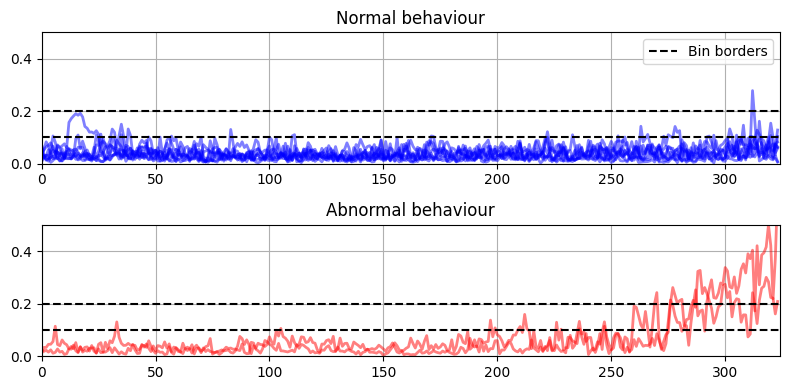

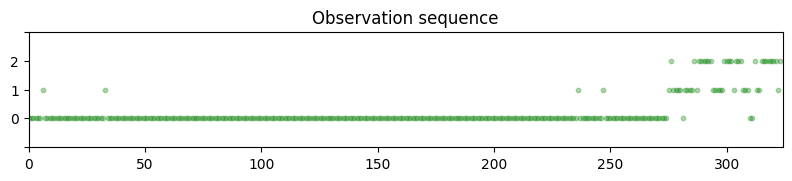

In [75]:

fig, ax = plt.subplots(2)
fig.set_size_inches(8,4)

linewidth = 2.0


for k, row in enumerate(residual_means):
    label = str(good_data[k]["label"].iloc[0])
    

    if label == "normal":
        ax[0].plot(row, alpha=0.5, color="blue", linewidth=linewidth)
    else:
        ax[1].plot(row, alpha=0.5, color="red", linewidth=linewidth)
for _ax in ax:
    _ax.grid()
    _ax.set_ylim(0,0.5)
    _ax.set_xlim(0, 324)
    _ax.hlines(bin_borders, 0, 324, colors="black", linestyles='dashed', label="Bin borders")
ax[0].legend()
ax[0].set_title("Normal behaviour")
ax[1].set_title("Abnormal behaviour")
plt.tight_layout()
plt.savefig("signals.png", dpi=300, bbox_inches="tight")
plt.show()

window_size= 20
plt.gcf().set_size_inches(9.73,1.5)

plt.scatter(range(len(observations[3])),observations[3], c="green", alpha=0.3, s=10.0)
# plt.plot(range(window_size//2, len(observations[1]) - window_size//2 + 1), np.convolve(observations[1], np.ones(window_size), mode="valid")/window_size, "black")
plt.xlim(0, 324)
plt.yticks((-1, 0,1,2, 3),("", 0,1,2, ""))
plt.title("Observation sequence")
plt.savefig("observations.png", dpi=300, bbox_inches="tight")
plt.show()


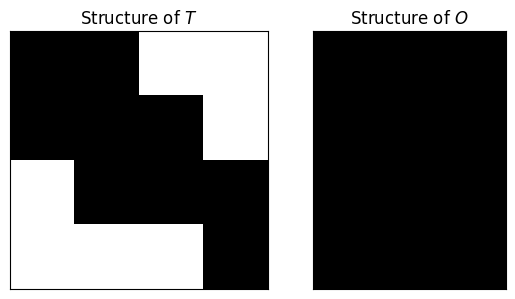

In [142]:
n = 4
m = 3

T_structure = jnp.tril(jnp.triu(jnp.ones((n,n), dtype=jnp.float64), k = -1), k=1)
T_structure = T_structure.at[-1, :-1].set(0.0)

O_structure = jnp.ones((n, m), dtype=jnp.float64)
# O_structure = O_structure.at[-1, :-1].set(0.0)
# O_structure = O_structure.at[:-1, -1].set(0.0)


mu = jnp.array([0.8, 0.2] + [0.0]*(n-2))

fig, ax = plt.subplots(1,2, width_ratios=(n, m))
ax[0].spy(T_structure)
ax[0].set_title("Structure of $T$")
ax[1].spy(O_structure)
ax[1].set_title("Structure of $O$")
for coord in (0, 1):
    ax[coord].set_xticks([])
    ax[coord].set_yticks([])
plt.savefig("structure.png",dpi=300, bbox_inches='tight',)
plt.show()

In [143]:
from functools import partial
from inference import baum_welch_log
from tqdm import tqdm

@partial(jax.jit, static_argnames=["batch_size", "parallel_batches"])
def fit_parallel(
    rng_key,
    obs, 
    T_structure, 
    O_structure, 
    mu, 
    batch_size: int = 10, 
    parallel_batches: int = 1000):

    batch_key, *key_arr = split(rng_key, 1 + parallel_batches)
    train_batches = jax.random.choice(batch_key, len(observations), (parallel_batches, batch_size), replace=True)

    def fit(rng_key, batch):
        key_T, key_O = split(rng_key)

        _T = uniform(key_T, T_structure.shape) * T_structure
        _O = uniform(key_O, O_structure.shape) * O_structure

        _T = _T / jnp.sum(_T, axis=1)[:, None]
        _O = _O / jnp.sum(_O, axis=1)[:, None]

        # return baum_welch(batch, _T, _O, mu, epsilon=1e-3)
        return baum_welch_log(batch, _T, _O, mu, epsilon=1e-12, max_iter=1000)


    _T_arr, _O_arr = jax.vmap(fit, in_axes=(0, 0))(jnp.array(key_arr), obs[train_batches])
    
    return _T_arr, _O_arr


In [ ]:

n_runs = 5
_T_list = []
_O_list = []

rng_key = key(0)

for run in tqdm(range(n_runs)):
    rng_key, run_key = split(rng_key)
    T_arr, O_arr = fit_parallel(run_key, observations, T_structure, O_structure,  mu)

    _T_list.append(T_arr.copy())
    _O_list.append(O_arr.copy())

print("Precision\nT:", T_arr.dtype, "\nO:", O_arr.dtype)

  0%|          | 0/5 [00:00<?, ?it/s]

In [123]:
T_arr = jnp.concat(_T_list)
O_arr = jnp.concat(_O_list)

T_arr

Array([[[6.808e-01, 2.451e-01, 7.413e-02, 0.000e+00],
        [6.734e-01, 2.291e-01, 9.555e-02, 2.004e-03],
        [0.000e+00, 6.176e-01, 3.693e-01, 1.310e-02],
        [0.000e+00, 0.000e+00, 0.000e+00, 1.000e+00]],

       [[7.196e-03, 5.239e-01, 4.689e-01, 0.000e+00],
        [5.338e-01, 4.874e-02, 4.175e-01, 5.252e-06],
        [0.000e+00, 9.040e-01, 9.275e-02, 3.219e-03],
        [0.000e+00, 0.000e+00, 0.000e+00, 1.000e+00]],

       [[3.771e-01, 5.301e-02, 5.699e-01, 0.000e+00],
        [3.739e-01, 5.239e-02, 5.709e-01, 2.850e-03],
        [0.000e+00, 1.733e-01, 8.261e-01, 5.750e-04],
        [0.000e+00, 0.000e+00, 0.000e+00, 1.000e+00]],

       ...,

       [[7.501e-01, 9.335e-02, 1.566e-01, 0.000e+00],
        [5.478e-01, 1.832e-01, 2.640e-01, 5.007e-03],
        [0.000e+00, 4.033e-01, 5.924e-01, 4.237e-03],
        [0.000e+00, 0.000e+00, 0.000e+00, 1.000e+00]],

       [[7.009e-01, 6.110e-02, 2.380e-01, 0.000e+00],
        [2.427e-01, 3.383e-01, 6.249e-02, 3.565e-01],
       

Valid indices: 5000 / 5000


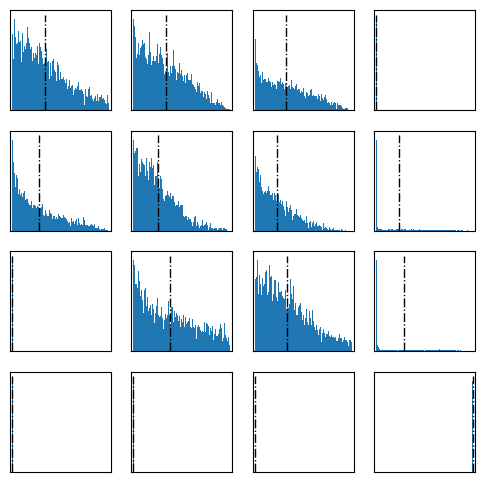

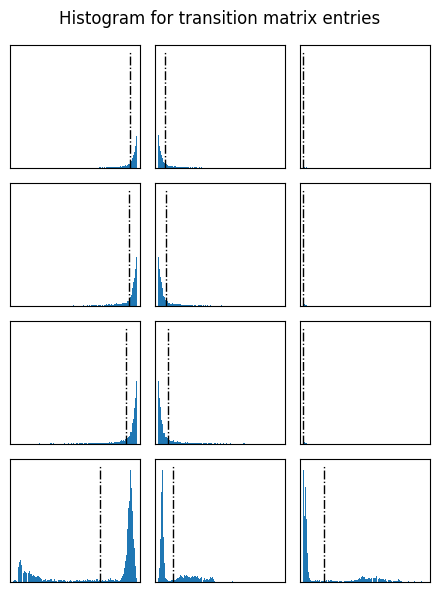

In [124]:
fig, axs = plt.subplots(n, n)
valid_indices = jnp.sum(jnp.isnan(T_arr), axis=(-1,-2)) == 0

print("Valid indices:", jnp.sum(valid_indices),"/",len(valid_indices))

bins = 150

T_mode = jnp.zeros_like(T_structure)
O_mode = jnp.zeros_like(O_structure)

fig.set_size_inches(1.5*n,1.5*n)
for i in range(n):
    for j in range(n):
        counts, bin_edges = jnp.histogram(T_arr[valid_indices, i, j], bins=bins)

        mode_idx = jnp.argmax(counts)
        mode_val = jnp.mean(bin_edges[mode_idx:mode_idx+2])

        T_mode = T_mode.at[i,j].set(mode_val)
        
        axs[i,j].hist(jnp.array(T_arr[valid_indices,i,j]), density=True, bins=bins, range=(0.0,1.0))
        axs[i,j].set_xlim(-0.02,1.02)
        axs[i,j].vlines(jnp.mean(T_arr[valid_indices,i,j]), *axs[i,j].get_ylim(), "k", linewidth=1.0, linestyle="-.")
        axs[i,j].set_yticks([])
        axs[i,j].set_xticks([])
        # axs[i,j].set_ylim(0,4)
plt.show()
fig, axs = plt.subplots(n,m)
fig.set_size_inches(1.5*m,1.5*n)
for i in range(n):
    for j in range(m):
        counts, bin_edges = jnp.histogram(O_arr[valid_indices, i, j], bins=bins)

        mode_idx = jnp.argmax(counts)
        mode_val = jnp.mean(bin_edges[mode_idx:mode_idx+2])
        
        O_mode = O_mode.at[i,j].set(mode_val)

        axs[i,j].hist(jnp.array(O_arr[valid_indices,i,j]), density=True, bins=bins, range=(0.0,1.0))
        axs[i,j].set_xlim(-0.02,1.02)
        axs[i,j].vlines(jnp.mean(O_arr[valid_indices,i,j]), *axs[i,j].get_ylim(), "k", linewidth=1.0, linestyle="-.")
        axs[i,j].set_yticks([])
        axs[i,j].set_xticks([])
        # axs[i,j].set_ylim(0,4)

fig.suptitle(f"Histogram for transition matrix entries")
plt.tight_layout()
plt.show()

T_mode = T_mode * T_structure
O_mode = O_mode * O_structure
T_mode = T_mode / jnp.sum(T_mode, axis=-1)[:, None]
O_mode = O_mode / jnp.sum(O_mode, axis=-1)[:, None]

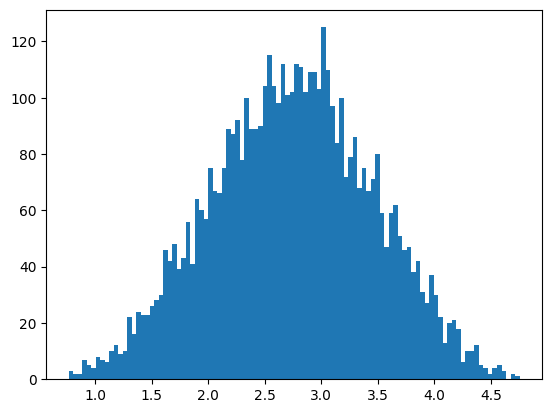

2


Array([[9.776e-01, 2.237e-02, 8.834e-11],
       [9.874e-01, 1.262e-02, 1.464e-08],
       [9.735e-01, 2.648e-02, 1.957e-07],
       [9.298e-01, 3.943e-02, 3.079e-02]], dtype=float64)

In [137]:
scores = jnp.sum(jnp.abs(T_arr - T_mode[None, ...]), axis=(1,2))

plt.hist(scores, bins=100)
plt.show()

best_tries = scores < 0.8

T_best = jnp.mean(T_arr[best_tries], axis=0)
O_best = jnp.mean(O_arr[best_tries], axis=0)

print(sum(best_tries))
O_best


T best:
 [[0.854 0.099 0.047 0.   ]
 [0.297 0.259 0.148 0.296]
 [0.    0.138 0.657 0.204]
 [0.    0.    0.    1.   ]]

O best:
 [[9.776e-01 2.237e-02 8.834e-11]
 [9.874e-01 1.262e-02 1.464e-08]
 [9.735e-01 2.648e-02 1.957e-07]
 [9.298e-01 3.943e-02 3.079e-02]]


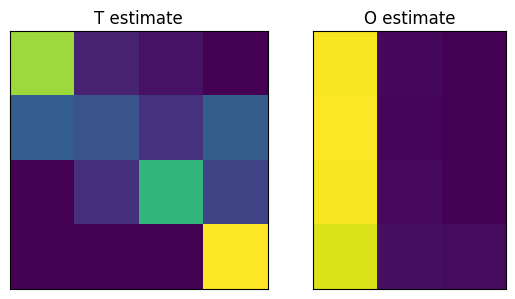

In [138]:
print("\nT best:\n", T_best)
print("\nO best:\n", O_best)

fig, axs = plt.subplots(1,2, width_ratios=(n, m))
axs[0].imshow(T_best)
axs[1].imshow(O_best)
axs[0].set_title("T estimate")
axs[1].set_title("O estimate")
for coord in (0, 1):
    axs[coord].set_xticks([])
    axs[coord].set_yticks([])
plt.savefig("result.png",dpi=300, bbox_inches='tight',)
plt.show()

assert jnp.allclose(jnp.sum(T_mode, axis=-1), 1)

In [139]:
latex_T = "P = \\begin{bmatrix}"
latex_O = "O = \\begin{bmatrix}"

for row in T_best:
    latex_T += f"{row[0]:.3f} & {row[1]:.3f} & {row[2]:.3f} & {row[3]:.3f} \\\\ \n".replace("0.000", "0").replace("1.000", "1")
latex_T += " \\end{bmatrix}"

for row in O_best:
    latex_O += f"{row[0]:.3f} & {row[1]:.3f}, {row[2]:.3f} \\\\ \n".replace("0.000", "0").replace("1.000", "1")
latex_O += " \\end{bmatrix}"
print(latex_T)
print(latex_O)

print(O_best)

P = \begin{bmatrix}0.854 & 0.099 & 0.047 & 0 \\ 
0.297 & 0.259 & 0.148 & 0.296 \\ 
0 & 0.138 & 0.657 & 0.204 \\ 
0 & 0 & 0 & 1 \\ 
 \end{bmatrix}
O = \begin{bmatrix}0.978 & 0.022, 0 \\ 
0.987 & 0.013, 0 \\ 
0.974 & 0.026, 0 \\ 
0.930 & 0.039, 0.031 \\ 
 \end{bmatrix}
[[9.776e-01 2.237e-02 8.834e-11]
 [9.874e-01 1.262e-02 1.464e-08]
 [9.735e-01 2.648e-02 1.957e-07]
 [9.298e-01 3.943e-02 3.079e-02]]


In [140]:
def plot_stats(states, observations, save=None):
    fig, ax = plt.subplots(1, 3)
    fig.set_size_inches(12,4)

    ax[0].set_title("Mean state evolution over time")
    ax[0].plot(jnp.mean(states, axis=0))
    ax[0].grid()
    ax[0].set_xlabel("Time step")
    ax[0].set_ylabel("State")

    obs_distribution = lax.map(lambda o: jnp.count_nonzero(observations == o, axis=0), jnp.arange(m)) / observations.shape[0]
    for k, obs_prob in enumerate(obs_distribution):
        ax[1].plot(obs_prob, label=f"$o^{k}$")
    ax[1].set_title("Observation distribution over time")
    ax[1].grid()
    ax[1].legend()
    ax[1].set_xlabel("Time step")
    ax[1].set_ylabel("$p(o_t)$")

    state_distribution = lax.map(lambda s: jnp.count_nonzero(states == s, axis=0), jnp.arange(n)) / states.shape[0]
    for k, state_prob in enumerate(state_distribution):
        ax[2].plot(state_prob, label=f"$s^{k}$")
    ax[2].set_title("State distribution over time")
    ax[2].set_xlabel("t")
    ax[2].set_ylabel("$p(s_t)$")
    ax[2].grid()
    ax[2].legend()

    plt.tight_layout()
    if save is not None:
        plt.savefig(save, dpi=300)
    plt.show()


Histogram mode parameters


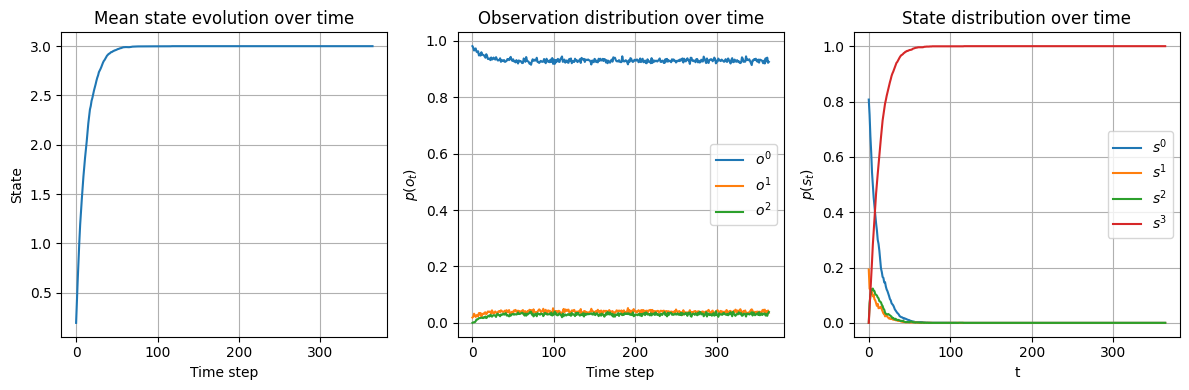

In [141]:
from generation import generate_sequence
len_sequence = 365
print("Histogram mode parameters")
states_approx, obs_approx = jax.vmap(lambda _key: generate_sequence(_key, T_best, O_best, mu, len_sequence))(jnp.array(split(key(0), 2000)))
plot_stats(states_approx, obs_approx, save="output.png")

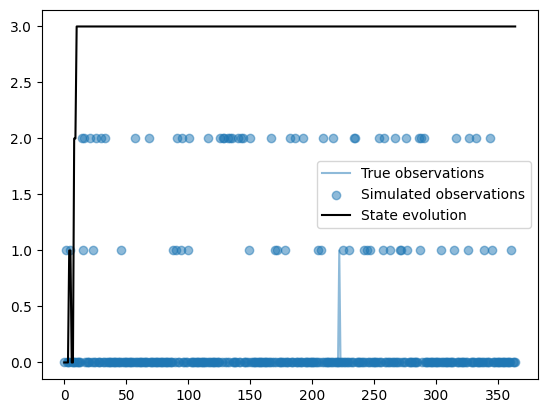

In [132]:
k=11
plt.plot(observations[1], label="True observations", alpha=0.5)
plt.scatter(range(len_sequence), obs_approx[k], label="Simulated observations", alpha=0.5)
plt.plot(states_approx[k],"k", label="State evolution")
plt.legend()
plt.show()

TypeError: unsupported operand type(s) for |: 'NoneType' and 'jaxlib._jax.PjitFunction'

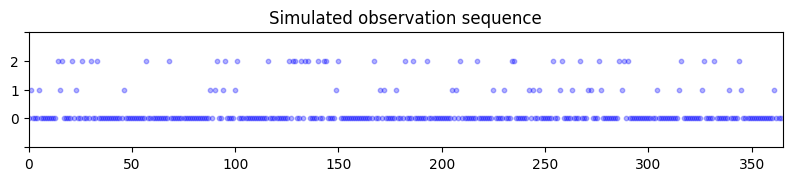

In [133]:

plt.gcf().set_size_inches(9.73,1.5)
plt.scatter(range(len_sequence), obs_approx[k], c="b", alpha=0.3, s=10.0)
# plt.plot(range(window_size//2, len(observations[1]) - window_size//2 + 1), np.convolve(observations[1], np.ones(window_size), mode="valid")/window_size, "black")
plt.xlim(0, 365)
plt.yticks((-1, 0,1,2, 3),("", 0,1,2, ""))
plt.title("Simulated observation sequence")
plt.savefig("simulated.png", dpi=300, bbox_inches="tight")| jnp.triu
plt.show()


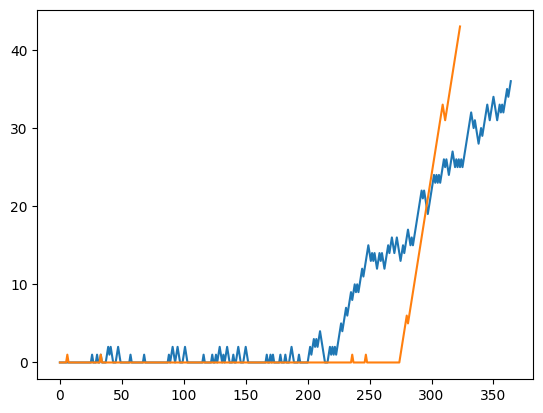

In [108]:
test = obs_approx[11]
plt.plot(criticality(test, 0.1))
plt.plot(criticality(observations[3], 0.1))
plt.show()